In [18]:
%matplotlib inline

from __future__ import division
import numpy as np
import menpo.io as mio
from menpo.image import Image
from menpo.feature import greyscale, normalize_norm, normalize_std, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, progress_bar_str
from menpofit.visualize import visualize_fitting_results
from alaborticcv2015.alignment import LKFitter, FilteredSSD, FilteredFourierSSD

# LDCK LK

Load training data:

In [19]:
images = []
for i in mio.import_images('/data/PhD/DataBases/faces/multipie/', verbose=True, 
                           max_images=66):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    labeller(i, 'PTS', ibug_face_66)
    lms = i.landmarks['ibug_face_66'].lms
    bb = lms.bounding_box()
    i.landmarks['bounding_box'] = bb
    images.append(i)

- Loading 66 assets: [====================] 100%

In [26]:
indices = [[j + k for j in range(3)] for k in range(6, 66, 15)]
indices = [j for k in indices for j in k] 

template = images[indices[0]]
test_images = [images[j] for j in indices][:3]

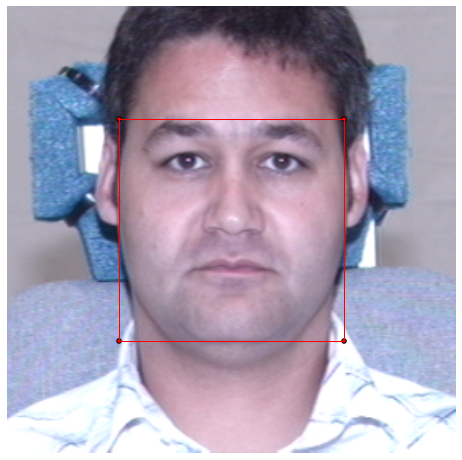

In [27]:
visualize_images(template)

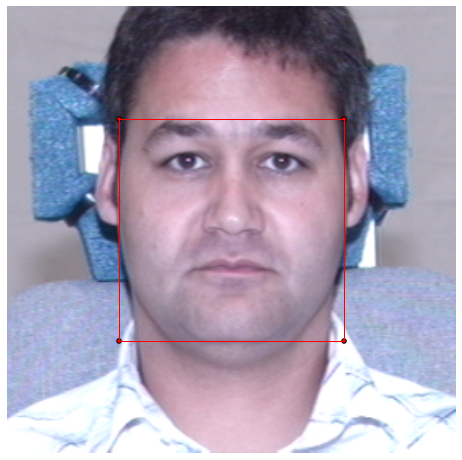

In [28]:
visualize_images(test_images)

Create an LK fitter:

In [29]:
n_filters = range(4, 34, 4)
shapes = [s for s in range(3, 9, 2)]

Align:

In [118]:
n_rep = 50

for nf in [32]:
    for s in [5]:
        
        print '- Network {}, {}: '.format(nf, s)
        
        # load network
        file_name = ('/data/PhD/Models/alaborticcv2015/pca_net/pca_net_2_3_' 
                     + str(nf) 
                     + '_' 
                     + str(s)
                     + '.pkl.gz') 
        net = mio.import_pickle(file_name)
        
        kernel0 = net._compute_kernel(layer=0, ext_shape=(36, 36))
        kernel1 = net._compute_kernel(layer=2, ext_shape=(72, 72))
        
        # create LK fitter
        fitter = LKFitter(template,
                          group='bounding_box',
                          features=greyscale,
                          diagonal=100,
                          #scales=(1,),
                          residual_cls=FilteredFourierSSD,
                          kernel=[kernel0, kernel1])

        np.random.seed(seed=1)
        fitter_results = []
        for j, i in enumerate(test_images):
            string = '  - Image {}: '.format(j)

            frs = []
            for k in range(n_rep):
                print_dynamic('{}{}'.format(
                    string, progress_bar_str(k/n_rep, show_bar=True)))

                gt_s = i.landmarks['bounding_box'].lms
                s = fitter.perturb_shape(gt_s, noise_std=10)
                fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=50)
                fr.downscale = 0.5
                frs.append(fr)

            fitter_results += frs

            errors = [fr.final_error() for fr in frs]    
            mean = np.mean(errors)
            median = np.median(errors)
            std = np.std(errors)

            print_dynamic(string + 
                          '\tmean={0:.4f}  median={1:.4f}  std={2:.4f}\n'.format(mean, median, std))

        errors = [fr.final_error() for fr in fitter_results]    
        mean = np.mean(errors)
        median = np.median(errors)
        std = np.std(errors)

        print_dynamic('  - Total:   ' + 
                      '\tmean={0:.4f}  median={1:.4f}  std={2:.4f}\n'.format(mean, median, std))

- Network 32, 5: 
  - Image 0: 	mean=0.0337  median=0.0053  std=0.0647
  - Image 1: 	mean=0.0905  median=0.0714  std=0.0662
  - Image 2: 	mean=0.0442  median=0.0134  std=0.0589
  - Total:   	mean=0.0562  median=0.0142  std=0.0680


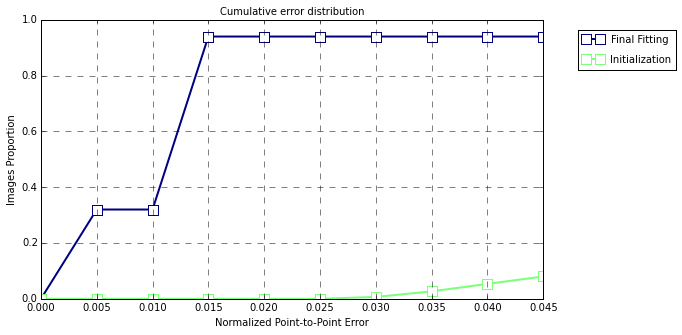

In [115]:
visualize_fitting_results(fitter_results)

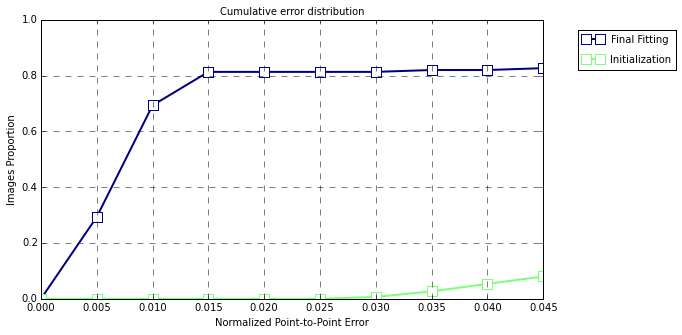

In [74]:
visualize_fitting_results(fitter_results)

In [95]:
a = net.kernels_frequency(ext_shape=(36, 36))

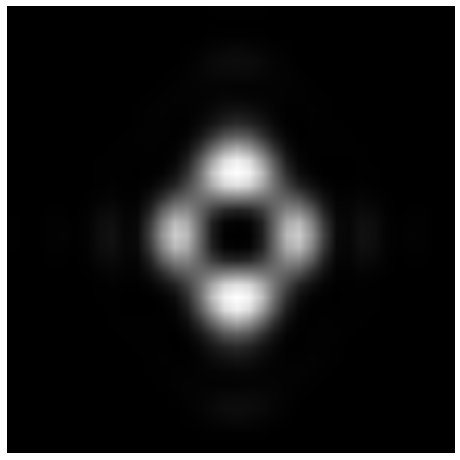

In [96]:
visualize_images(a)

/data/PhD/multipie


In [120]:
from scipy.io.matlab import loadmat

In [128]:
aux = loadmat('/data/matlabdev/face_recognition_2011/data/myARCropped.mat')

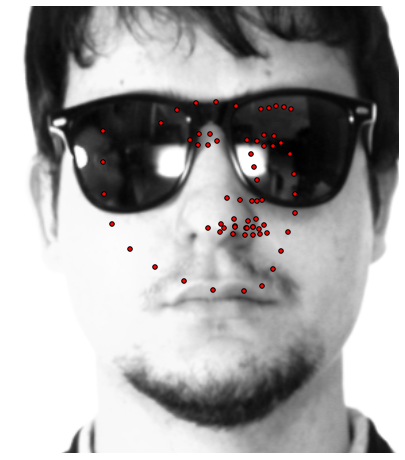

IndexError: list index out of range

In [132]:
i = Image(aux['example_imgs'][0][0])
i.landmarks['a'] = images[0].landmarks['PTS']
i.view_widget() 

In [130]:
aux['coords'][0]

array([ 65,  60, 235, 260], dtype=uint16)